In [1]:
"""
Próximos passos: 
 OK => Fazer o onehotencode no dataset inteiro
 OK => Verificar a importância de cada atributo em relação ao sit_matricula
 OK => Utilizar o standtscaler para reescalar os dados
 OK => Treinar novamente com o dataset inteiro
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DEBUG = False
SUBSET_DIAS = 9

## Tratando os dados

### Importando o dataset e removendo colunas não necessárias

In [2]:
dataset_original = pd.read_csv('data/sei.csv')

dataset = dataset_original.copy()
"""
Para isso, inicialmente iremos melhorar os dados do nosso dataset, removendo alguns atributos considerados 
desnecessários. Primeiramente removeremos os atributos referentes às notas máximas de determinada atividade,
visto que esse valor sempre será 100.
"""

"""
30/03 
Alguns dados defeituosos serão removidos para que não influenciem negativamente os testes

1101 => Aprovado, com notas nas atividades mas sem dias
165 => Fez as atividades mas algumas passaram de 1 mês
331, 382 => Data de entrega das atividades inferior ao dia de matricula 
(considerando-se dt_inscricao e não dt_fim_inscricao)
"""
dataset.drop(index=[1101, 165, 331, 382])

# Filtramos todas as colunas do dataset que possuem o valor da nota máxima da atividade X:
notas_maximas_a_remover = dataset.filter(like='nota_maxima_atividade')


# Filtramos também alguns índices e id's que não serão necessários no momento
indices_e_ids_a_remover = [
    "index", 
     "id_inscricao", 
     "id_oferta_x", 
     "id_curso", 
     "qt_carga_horaria_oferta",
     "qt_duracao_dias",
     "id_pessoa",
     "nota_maxima_curso",
     "tx_nome_orgao"
]

# E também algumas datas que podem não ser muito úteis num momento inicial
datas_a_remover = [
    "dt_fim_inscricao",
    "dt_nascimento"
]

dataset = dataset.drop(
    [*indices_e_ids_a_remover, *datas_a_remover,  *list(notas_maximas_a_remover), "nota_final_aluno_curso", "data_termino_curso_aluno"], 
    axis=1
)

# E iremos alterar os valores do 'sit_matricula'
dataset = dataset.replace({"CERTIFICADO": "APROVADO", "CANC_DESISTENTE": "TRANCAMENTO"})

### Tratando as datas

In [3]:
"""
Para podemos calcular os dias temos que antes trabalhar as linhas que não possuem valores (NaN).
Poderíamos remover as linhas com esses valores, mas isso reduziria consideravelmente o tamanho do nosso dataset.
Então iremos por outra abordagem: inserir um valor padrão nessas linhas. Será inserida o datetime 
"2000-01-01 00:00"
"""

# Preenchemos todos as entradas com  '2000-01-01 00:00' no lugar de 'nan' 
def insert_default_date_time(dataset):
    datas_a_inserir = dataset.filter(like='data_entrega_atividade_')
    datas_a_inserir = datas_a_inserir.fillna(pd.to_datetime("2000-01-01 00:00:00"))
    dataset.fillna(datas_a_inserir, inplace=True)
    return dataset

# Convertemos os campos de datas em date_times:
def convert_columns_to_date_time(dataset, columns_name):
    date_time_columns = pd.to_datetime(dataset[[*columns_name]].stack(), dayfirst=True)
    date_time_columns = date_time_columns.dt.normalize()
    dataset[[*columns_name]] = date_time_columns.unstack()
    return dataset


dataset = insert_default_date_time(dataset)

date_columns = [*list(dataset.filter(like='data_entrega_atividade_')), "dt_inscricao"]

dataset = convert_columns_to_date_time(dataset, date_columns)

### Adicionando dias entre atividade X e matrícula

In [4]:
"""
Após preenchermos os campos de datas com valores padrões nas linhas que não tinham valor algum, enfim podemos
inserir as novas colunas que contém a contagem de dias entre a efetivação da matricula e a relização da tarefa X
"""

# Criamos uma função que irá fazer esse cálculo e retornar um dataframe com as novas colunas
def calculate_dates_between(df_initial_date, df_list_of_dates, columns_name):
    # Geramos um novo dataframe que irá comportar as diferenças entre as datas
    df_dates_between = pd.DataFrame()

    # Fazemos o calculo das diferenãs entre datas, inserindo no dataframe criado acima
    for index, item in enumerate(df_list_of_dates):
        df_dates_between[f'{columns_name}_{index+1}'] = (df_list_of_dates[item] - df_initial_date).dt.days
    
    # E setamos todos os valores < 0  = -1
    df_dates_between = df_dates_between.clip(lower=-1)

    return df_dates_between

initial_date = dataset["dt_inscricao"]
list_of_dates = dataset.filter(like='data_entrega_atividade_')

dif_between_dates = calculate_dates_between(
    initial_date, 
    list_of_dates, 
    columns_name='dias_atividade',
)

# Por fim, inserimos essas novas colunas no nosso df_filtrado:
dataset[[*list(dif_between_dates)]] = dif_between_dates
dataset = dataset.drop([*list_of_dates.columns], axis=1)

In [5]:
n_dias = [1,SUBSET_DIAS + 1]

### Populando com colunas de atividades feitas até o dia N

In [6]:
"""
Como temos agora as colunas com os dias entre matricula e realização de atividades, podemos calcular o número
de atividades feitas até N dias. Para isso criaremos outra função:
"""

def populate_by_range_days(dataset, n_dias, column_name = 'atividades_ate_dia_'):
    for i in range(*n_dias):
        dias_atividades = dataset.filter(like="dias_atividade")
        dias_atividades = dias_atividades[(dias_atividades <= i) & (dias_atividades != -1)].replace({0: True})
        dias_atividades = dias_atividades.fillna(False)
        dias_atividades = dias_atividades.astype('bool')
        dataset[f"atividades_ate_dia_{i}"] = dias_atividades.sum(axis=1)
    return dataset


dataset = populate_by_range_days(dataset, n_dias=n_dias)

"""
Como a data de inscrição já não importa mais, iremos remover ela também.
"""
dataset = dataset.drop("dt_inscricao", axis=1)

### Tratando dados faltantes

In [7]:
"""
Para podermos seguir com a utlização de algoritmos, temos antes que tratar os dados faltantes. Primeiramente 
devemos ver quais colunas possuem dados faltantes (ou NaN).

"""
dataset.columns[dataset.isnull().any()].tolist()

['sg_uf',
 'sg_pais',
 'tp_poder_execut_legisl_judic',
 'esfera',
 'nota_aluno_atividade_1',
 'nota_aluno_atividade_2',
 'nota_aluno_atividade_3',
 'nota_aluno_atividade_4',
 'nota_aluno_atividade_5',
 'nota_aluno_atividade_6',
 'nota_aluno_atividade_7',
 'nota_aluno_atividade_8',
 'nota_aluno_atividade_9',
 'nota_aluno_atividade_10',
 'nota_aluno_atividade_11',
 'nota_aluno_atividade_12',
 'nota_aluno_atividade_13',
 'nota_aluno_atividade_14',
 'nota_aluno_atividade_15',
 'nota_aluno_atividade_16',
 'nota_aluno_atividade_17',
 'nota_aluno_atividade_18']

In [8]:
#Para as notas, podemos assumir que valores nulos são atividades não feitas. dessas forma:
dataset[dataset.filter(like='nota_aluno_atividade').columns] = dataset.filter(like='nota_aluno_atividade').fillna(0)

# Para as demais simplesmente inserimos 'sem_{}'
dataset['sg_uf'] = dataset['sg_uf'].fillna('sem_uf')
dataset['tp_poder_execut_legisl_judic'] = dataset['tp_poder_execut_legisl_judic'].fillna('sem_tp_poder')
dataset['esfera'] = dataset['esfera'].fillna('sem_esfera')
dataset['sg_pais'] = dataset['sg_pais'].fillna('sem_pais')


### Fazendo o encode no dataset 

In [10]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode
        self.encoded_columns = []
        
    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            
            self.encoded_columns = pd.get_dummies(output[self.columns])
            output = output.drop(columns_to_encode, axis = 1)
            output = output.join(self.encoded_columns)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


columns_to_encode = [
    'sg_uf', 
    'tp_sexo', 
    'sg_pais', 
    'sit_matricula',
    'tp_servidor_militar_cidadao',
    'tp_poder_execut_legisl_judic',
    'esfera'
]

matricula = dataset['sit_matricula']

dataset = MultiColumnLabelEncoder(columns_to_encode).fit_transform(dataset)

### Verificando a importância dos atributos em relação ao sit_matricula

In [11]:
pd.options.display.max_rows = 400

corr_matrix = dataset.corr()
print(corr_matrix['sit_matricula_APROVADO'].sort_values(ascending=False))

sit_matricula_APROVADO                       1.000000
nota_aluno_atividade_9                       0.979613
nota_aluno_atividade_7                       0.976175
nota_aluno_atividade_5                       0.973719
nota_aluno_atividade_8                       0.973534
nota_aluno_atividade_6                       0.970459
nota_aluno_atividade_2                       0.962630
nota_aluno_atividade_1                       0.960906
nota_aluno_atividade_10                      0.959570
nota_aluno_atividade_4                       0.956980
nota_aluno_atividade_12                      0.953273
nota_aluno_atividade_13                      0.952820
nota_aluno_atividade_3                       0.939543
nota_aluno_atividade_14                      0.925993
nota_aluno_atividade_11                      0.916812
nota_aluno_atividade_15                      0.916237
nota_aluno_atividade_16                      0.913994
nota_aluno_atividade_17                      0.913380
nota_aluno_atividade_18     

In [12]:
print(corr_matrix['sit_matricula_ABANDONO'].sort_values(ascending=False))

sit_matricula_ABANDONO                       1.000000
sg_pais_sem_pais                             0.164940
tp_servidor_militar_cidadao_S                0.138941
tp_poder_execut_legisl_judic_E               0.128471
esfera_M                                     0.090836
sg_uf_BA                                     0.086418
sg_uf_RN                                     0.058705
sg_uf_SP                                     0.058001
tp_sexo_F                                    0.049835
tp_servidor_militar_cidadao_C                0.047352
sg_uf_DF                                     0.043925
sg_uf_PE                                     0.039349
esfera_sem_esfera                            0.037722
esfera_F                                     0.033523
tp_poder_execut_legisl_judic_O               0.029549
sg_uf_CE                                     0.025227
tp_poder_execut_legisl_judic_L               0.023253
tp_servidor_militar_cidadao_SV               0.022102
sg_uf_RO                    

In [13]:
print(corr_matrix['sit_matricula_TRANCAMENTO'].sort_values(ascending=False))

sit_matricula_TRANCAMENTO                    1.000000
esfera_F                                     0.024889
sg_pais_KE                                   0.024574
tp_servidor_militar_cidadao_SV               0.019842
sg_pais_sem_pais                             0.019340
esfera_sem_esfera                            0.016058
sg_uf_PR                                     0.014143
tp_sexo_                                     0.013604
esfera_M                                     0.012436
sg_uf_BA                                     0.011998
sg_uf_SP                                     0.011642
tp_servidor_militar_cidadao_S                0.011508
sg_uf_DF                                     0.010917
sg_uf_RO                                     0.010357
tp_servidor_militar_cidadao_C                0.009090
tp_poder_execut_legisl_judic_J               0.009078
sg_uf_CE                                     0.008679
tp_poder_execut_legisl_judic_E               0.007900
sg_uf_PA                    

In [14]:
print(corr_matrix['sit_matricula_REPROVADO'].sort_values(ascending=False))

sit_matricula_REPROVADO                      1.000000
tp_poder_execut_legisl_judic_L               0.014336
sg_uf_MG                                     0.010490
dias_atividade_6                             0.009946
dias_atividade_18                            0.009939
dias_atividade_17                            0.009341
dias_atividade_5                             0.009059
dias_atividade_16                            0.008884
dias_atividade_7                             0.008826
dias_atividade_4                             0.008237
dias_atividade_8                             0.008066
dias_atividade_9                             0.007900
esfera_E                                     0.007727
dias_atividade_10                            0.007152
dias_atividade_12                            0.007131
dias_atividade_13                            0.007122
dias_atividade_14                            0.007105
dias_atividade_11                            0.007006
atividades_ate_dia_9        

In [15]:
print(corr_matrix['sit_matricula_DESISTENTE'].sort_values(ascending=False))

sit_matricula_DESISTENTE                     1.000000
nota_aluno_atividade_1                       0.049737
nota_aluno_atividade_2                       0.037300
dias_atividade_1                             0.035976
dias_atividade_2                             0.031257
sg_pais_BR                                   0.028574
dias_atividade_3                             0.024781
sg_uf_BA                                     0.024435
tp_servidor_militar_cidadao_ETR              0.021599
tp_servidor_militar_cidadao_SV               0.019794
sg_uf_MG                                     0.017561
dias_atividade_4                             0.013888
tp_poder_execut_legisl_judic_O               0.012934
esfera_sem_esfera                            0.012215
sg_pais_US                                   0.010508
tp_sexo_F                                    0.010308
sg_uf_AC                                     0.010265
sg_uf_RR                                     0.006286
sg_uf_AM                    

### Normalizando os dados

In [16]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer() 

dataset_non_scaled = dataset.copy()

#dataset[dataset.columns] = normalizer.fit_transform(dataset[dataset.columns])

In [17]:
dataset.describe()

,nota_aluno_atividade_1,nota_aluno_atividade_2,nota_aluno_atividade_3,nota_aluno_atividade_4,nota_aluno_atividade_5,nota_aluno_atividade_6,nota_aluno_atividade_7,nota_aluno_atividade_8,nota_aluno_atividade_9,nota_aluno_atividade_10,...,tp_servidor_militar_cidadao_SV,tp_poder_execut_legisl_judic_E,tp_poder_execut_legisl_judic_J,tp_poder_execut_legisl_judic_L,tp_poder_execut_legisl_judic_O,tp_poder_execut_legisl_judic_sem_tp_poder,esfera_E,esfera_F,esfera_M,esfera_sem_esfera
count,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,...,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000,79614.000000
mean,63.038787,63.467983,58.914575,60.473032,62.469830,61.975757,62.575426,62.346761,62.314020,56.401391,...,0.051285,0.493870,0.034617,0.006871,0.016919,0.447723,0.627302,0.227837,0.042417,0.102444
std,46.275976,46.658196,44.944650,45.465724,46.317858,46.183168,46.601149,46.690333,46.431924,43.022829,...,0.220580,0.499966,0.182809,0.082605,0.128969,0.497263,0.483526,0.419439,0.201540,0.303234
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,100.000000,75.000000,80.000000,100.000000,85.710000,100.000000,100.000000,94.740000,75.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,91.670000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Fazendo o encode do sit_matricula

In [18]:
df_enc = pd.Categorical(pd.factorize(matricula)[0])
ohe_df = pd.DataFrame({"resultado": df_enc})
dataset = pd.concat([dataset, ohe_df], axis=1)

resultados = dataset.filter(like="sit_matricula_")

dataset = dataset.drop(resultados, axis=1)

In [19]:
dataset.shape

(79614, 133)

## Treinando e avaliando os dados

In [20]:
dados_filtrados_X = dataset.drop('resultado', axis=1)
dados_filtrados_y = dataset['resultado']
dados_filtrados_y

0        0
1        1
2        0
3        0
4        0
        ..
79609    0
79610    1
79611    1
79612    4
79613    1
Name: resultado, Length: 79614, dtype: category
Categories (5, int64): [0, 1, 2, 3, 4]

In [21]:
"""
Classificadores usados em outros artigos:

Naive Bayes, => GaussianNB
LogisticRegression => LogisticRegression,
Ensemble => AdaBoostClassifier,RandomForestClassifier
SVM => LinearSVC,

Também utilizados:

Tree => DecisionTreeClassifier


Redes Neurais:
Multilayer Perceptron,
RBFNetwork,
RNN,
LSTM
"""

'\nClassificadores usados em outros artigos:\n\nNaive Bayes, => GaussianNB\nLogisticRegression => LogisticRegression,\nEnsemble => AdaBoostClassifier,RandomForestClassifier\nSVM => LinearSVC,\n\nTambém utilizados:\n\nTree => DecisionTreeClassifier\n\n\nRedes Neurais:\nMultilayer Perceptron,\nRBFNetwork,\nRNN,\nLSTM\n'

In [22]:
import numpy, time
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

result = ['APROVADO', 'ABANDONO', 'TRANCAMENTO', 'REPROVADO', 'DESISTENTE']

def train_and_evaluate(alg, treino_x, teste_x, treino_y, teste_y, show_distribuition = False):
    start = time.time()
    alg.fit(treino_x, treino_y)
    previsoes = alg.predict(teste_x)
    stop = time.time()

    acuracia = accuracy_score(teste_y, previsoes) * 100
    print("A acurácia foi %.2f%%" % acuracia)
    print(f"Tempo de execução:: {stop - start}s")
    
    show_confusion_matrix(teste_y, previsoes)
    
    if show_distribuition:
        show_previsions_and_results_distribuition(teste_y, previsoes)

def show_previsions_and_results_distribuition(teste_y, previsoes):
    fig, ax = plt.subplots()
    results = dict(zip(*numpy.unique(teste_y.values, return_counts=True)))
    predictions = dict(zip(*numpy.unique(previsoes, return_counts=True))) 

    labels = results.keys()
    print(labels)
    x = np.arange(len(labels))
    width = 0.35

    for key in list(results):
        results[result[key]] = results[key] 
        del results[key] 
        try:
            predictions[result[key]] = predictions[key] 
            del predictions[key] 
        except KeyError:
            predictions[result[key]] = 0                   

    print(results)
    print(predictions)
    rects1 = ax.bar(x - width/2, results.values(), width, label='Resultados')
    rects2 = ax.bar(x + width/2, predictions.values(), width, label='Previsões')
    ax.set_ylabel('Alunos')
    ax.set_title('Alunos por resultado')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ymargin(0.5)
    ax.legend()
    autolabel(rects1, ax)
    autolabel(rects2, ax)

    fig.tight_layout()

    plt.show()

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
def show_confusion_matrix(teste_y, previsoes):
    conf_mx = confusion_matrix(teste_y, previsoes)
    
    
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums

    # Preenchemos as diagonais com 0's para manter apenas os erros e plotar o resultado:
    np.fill_diagonal(norm_conf_mx, 0)
    
    # Onde as linhas representam as classes reais, e as colunas as classes previstas
    plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
    xticks = [i for i in range(0, conf_mx.shape[1])]
    yticks = [i for i in range(0, conf_mx.shape[0])]
    plt.xticks(xticks, result[0:conf_mx.shape[1]], rotation=90)
    plt.yticks(yticks, result[0:conf_mx.shape[0]])
    plt.show()
    
def calculate_with_grid_search(alg, param_grid, treino_x, teste_x, treino_y, teste_y):
    if DEBUG is False:
        grid_search = GridSearchCV(alg, param_grid = param_grid, cv=5, scoring="accuracy")

        grid_search.fit(treino_x, treino_y)

        # E obteremos a melhore combinação de parâmetros:
        best_params = grid_search.best_params_

        cvres = grid_search.cv_results_
        for score, params in zip(cvres['mean_test_score'], cvres['params']):
            score *= 100
            print("Precisão: ", score, "Parametros:", params)
        

### LinearSVC

A acurácia foi 98.86%
Tempo de execução:: 9.55127239227295s


/home/eliasb/Documentos/evasao_escolar/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


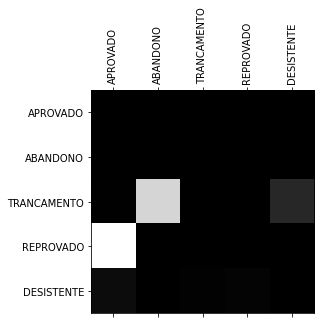

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 10337, 'ABANDONO': 5293, 'TRANCAMENTO': 169, 'REPROVADO': 2, 'DESISTENTE': 122}
{'APROVADO': 10344, 'ABANDONO': 5434, 'TRANCAMENTO': 2, 'REPROVADO': 4, 'DESISTENTE': 139}


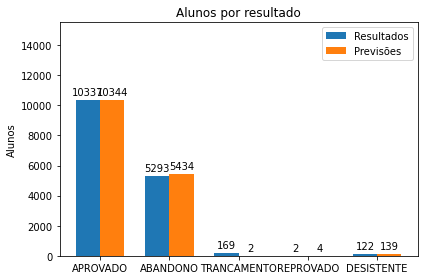

In [23]:
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split

treino_x, teste_x, treino_y, teste_y = train_test_split(dados_filtrados_X, dados_filtrados_y, test_size=0.2)


lin_reg = LinearSVC(dual=False, random_state=42)

train_and_evaluate(lin_reg, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

### GaussianNB

A acurácia foi 72.72%
Tempo de execução:: 0.14366984367370605s


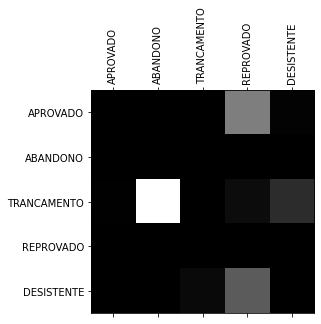

In [24]:
from sklearn.naive_bayes import GaussianNB

treino_x, teste_x, treino_y, teste_y = train_test_split(dados_filtrados_X, dados_filtrados_y, test_size=0.2)


gaussian_nb = GaussianNB()
train_and_evaluate(gaussian_nb, treino_x, teste_x, treino_y, teste_y)

### RandomForestClassifier

A acurácia foi 98.81%
Tempo de execução:: 4.1099464893341064s


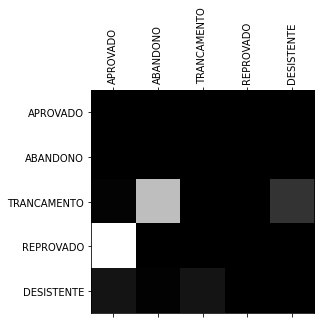

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 10375, 'ABANDONO': 5264, 'TRANCAMENTO': 169, 'REPROVADO': 1, 'DESISTENTE': 114}
{'APROVADO': 10387, 'ABANDONO': 5384, 'TRANCAMENTO': 23, 'REPROVADO': 0, 'DESISTENTE': 129}


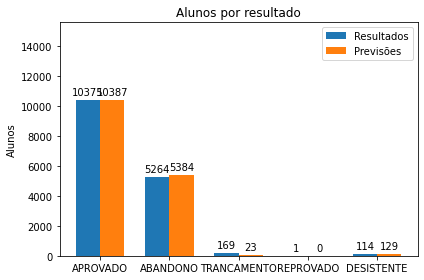

In [25]:
from sklearn.ensemble import RandomForestClassifier

treino_x, teste_x, treino_y, teste_y = train_test_split(dados_filtrados_X, dados_filtrados_y, test_size=0.2)


random_forest = RandomForestClassifier(random_state=42)
train_and_evaluate(random_forest, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

### AdaBoostClassifier

A acurácia foi 98.79%
Tempo de execução:: 5.412421941757202s


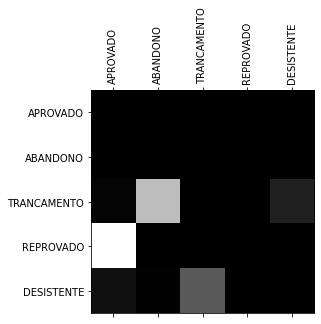

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 10375, 'ABANDONO': 5280, 'TRANCAMENTO': 159, 'REPROVADO': 1, 'DESISTENTE': 108}
{'APROVADO': 10382, 'ABANDONO': 5399, 'TRANCAMENTO': 55, 'REPROVADO': 0, 'DESISTENTE': 87}


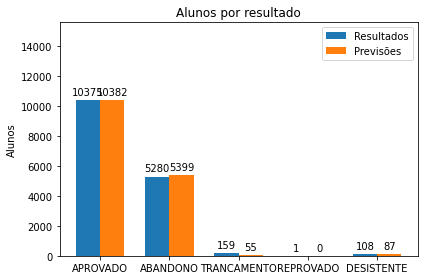

In [26]:
from sklearn.ensemble import AdaBoostClassifier

treino_x, teste_x, treino_y, teste_y = train_test_split(dados_filtrados_X, dados_filtrados_y, test_size=0.2)


adaboost = AdaBoostClassifier(random_state=42)
"""
Obs: a acurácia aqui variou bastante
"""

train_and_evaluate(adaboost, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

### LogisticRegression

A acurácia foi 98.88%
Tempo de execução:: 6.603531360626221s


/home/eliasb/Documentos/evasao_escolar/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


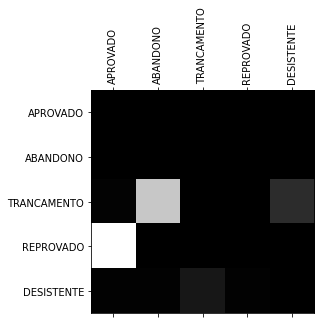

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 10389, 'ABANDONO': 5253, 'TRANCAMENTO': 169, 'REPROVADO': 1, 'DESISTENTE': 111}
{'APROVADO': 10393, 'ABANDONO': 5386, 'TRANCAMENTO': 15, 'REPROVADO': 1, 'DESISTENTE': 128}


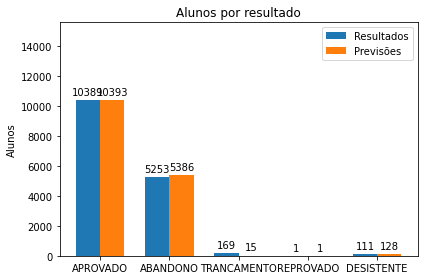

In [27]:
from sklearn.linear_model import LogisticRegression

treino_x, teste_x, treino_y, teste_y = train_test_split(dados_filtrados_X, dados_filtrados_y, test_size=0.2)


log_regression = LogisticRegression(random_state=42)

train_and_evaluate(log_regression, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

### DecisionTreeClassifier

A acurácia foi 98.72%
Tempo de execução:: 0.4402618408203125s


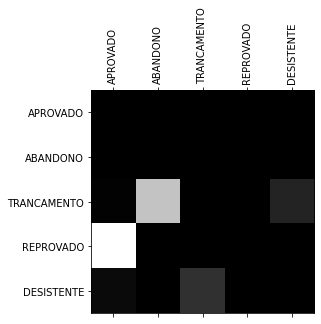

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 10306, 'ABANDONO': 5318, 'TRANCAMENTO': 171, 'REPROVADO': 1, 'DESISTENTE': 127}
{'APROVADO': 10301, 'ABANDONO': 5445, 'TRANCAMENTO': 44, 'REPROVADO': 2, 'DESISTENTE': 131}


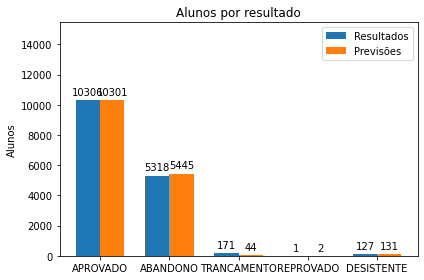

In [28]:
from sklearn.tree import DecisionTreeClassifier

treino_x, teste_x, treino_y, teste_y = train_test_split(dados_filtrados_X, dados_filtrados_y, test_size=0.2)


dec_tree = DecisionTreeClassifier(random_state=42)
train_and_evaluate(dec_tree, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

## Aplicando num subset

### Tratando os dados para obter a média das atividades de acordo com o número realizado até n dias

In [29]:
"""
Realizar todo o procedimento com um conjunto menor de dados (ex.: 5 dias); OK
 -> Fazer a média das n atividades que ela fez no período OK
 -> Levar em conta quantidade de atividades realizadas e média de notas; OK
 
Ler mais artigos sobre evasão escolar buscando informações e ideias de modelos;

"""


notas = dataset_non_scaled.filter(like="nota_aluno_atividade")
dias = dataset_non_scaled.filter(like="dias_atividade")

uf  = dataset.filter(like="sg_uf_")
sexo = dataset.filter(like="tp_sexo")
pais = dataset.filter(like="sg_pais_")
poder_servidor = dataset.filter(like="tp_")
esfera = dataset.filter(like='esfera_')

subset = dataset_non_scaled[[*list(notas), *list(dias)]]
subset = subset.copy()

for index, column in enumerate(subset):
    if 'nota_aluno_atividade' in column:
        n = int(column.replace('nota_aluno_atividade_',""))
        truty = (subset[f"dias_atividade_{n}"] <= SUBSET_DIAS) & (subset[f"dias_atividade_{n}"] != -1)
        subset[column] = subset[truty & subset[column]]

### Inserindo as médias e número de atividades feitas até dia n

In [30]:
subset = subset.drop(dias, axis=1).fillna(0)
notas = subset.filter(like="nota_aluno_atividade_")
subset['medias'] = notas.sum(axis=1)

subset['medias'] = (subset['medias']/dataset_non_scaled[f"atividades_ate_dia_{SUBSET_DIAS}"]).fillna(0)
subset[f'atividades_ate_dia_{SUBSET_DIAS}'] = dataset_non_scaled[f"atividades_ate_dia_{SUBSET_DIAS}"]
subset = subset.drop(notas, axis=1)

subset[subset.columns] = normalizer.fit_transform(subset[subset.columns])


In [31]:
subset

,medias,atividades_ate_dia_9
0,0.995974,0.089638
1,0.000000,0.000000
2,0.000000,1.000000
3,0.975610,0.219512
4,0.982318,0.187218
...,...,...
79609,0.984183,0.177153
79610,0.000000,0.000000
79611,0.000000,0.000000
79612,0.000000,0.000000


### Aplicando o subset em algoritmos de ML

#### LinearSVC

A acurácia foi 91.14%
Tempo de execução:: 0.13071775436401367s


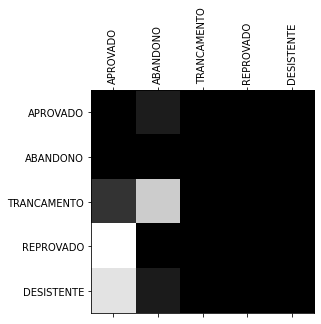

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 10314, 'ABANDONO': 5340, 'TRANCAMENTO': 158, 'REPROVADO': 1, 'DESISTENTE': 110}
{'APROVADO': 9304, 'ABANDONO': 6619, 'TRANCAMENTO': 0, 'REPROVADO': 0, 'DESISTENTE': 0}


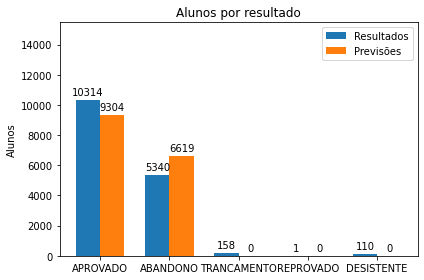

In [32]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


lin_reg = LinearSVC(dual=False, random_state=42)
train_and_evaluate(lin_reg, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

lin_reg_gs = LinearSVC()

param_grid = [
    {'loss': ['hinge'], 'penalty':  ['l2'], 'max_iter': [1000, 10000]},
    {'loss': ['squared_hinge'], 'dual': [False], 'penalty':  ['l1', 'l2'], 'max_iter': [1000, 10000]}

]

#calculate_with_grid_search(lin_reg_gs, param_grid, treino_x, teste_x, treino_y, teste_y)

#### GaussianNB

A acurácia foi 89.68%
Tempo de execução:: 0.011204719543457031s


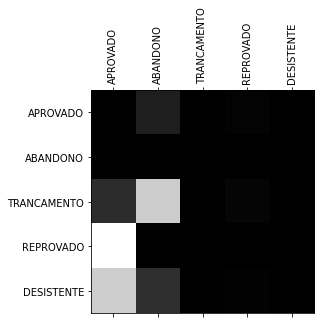

'\nOs únicos hiperparâmetros alteráveis aqui sao priors e var_smoothing, sendo o primeiro o tamanho de n classes e o \nsegundo já tendo um valor padrão (1e-9). Nesse cenário em específico não serão feitas alterações\n'

In [33]:
from sklearn.naive_bayes import GaussianNB

treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


gaussian_nb = GaussianNB()
train_and_evaluate(gaussian_nb, treino_x, teste_x, treino_y, teste_y)

"""
Os únicos hiperparâmetros alteráveis aqui sao priors e var_smoothing, sendo o primeiro o tamanho de n classes e o 
segundo já tendo um valor padrão (1e-9). Nesse cenário em específico não serão feitas alterações
"""

#### RandomForestClassifier

A acurácia foi 90.88%
Tempo de execução:: 1.2060341835021973s


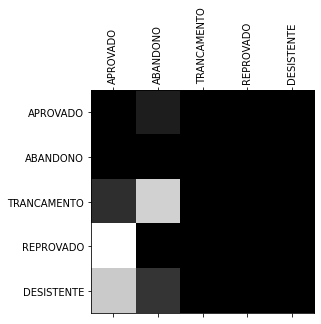

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 10264, 'ABANDONO': 5382, 'TRANCAMENTO': 166, 'REPROVADO': 1, 'DESISTENTE': 110}
{'APROVADO': 9207, 'ABANDONO': 6716, 'TRANCAMENTO': 0, 'REPROVADO': 0, 'DESISTENTE': 0}


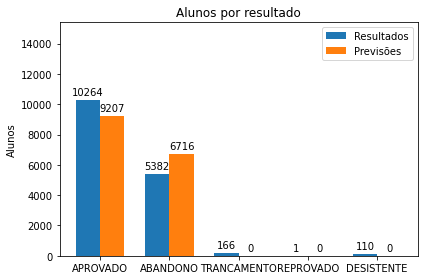

In [34]:
from sklearn.ensemble import RandomForestClassifier

treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


random_forest = RandomForestClassifier(random_state=42)
train_and_evaluate(random_forest, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

param_grid = [
    {'bootstrap': [False], 'n_estimators': [10, 30, 100, 300], 'n_jobs':[-1]},
    {'n_estimators': [10, 30, 100, 300], 'n_jobs':[-1]}
]


random_forest_gs = RandomForestClassifier()


#calculate_with_grid_search(random_forest_gs, param_grid, treino_x, teste_x, treino_y, teste_y)

#### AdaBoostClassifier

A acurácia foi 90.85%
Tempo de execução:: 0.9357128143310547s


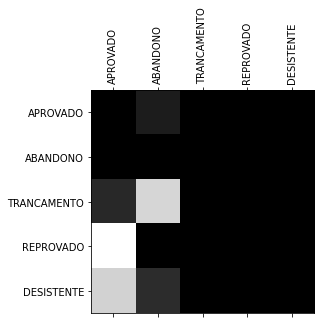

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 10400, 'ABANDONO': 5239, 'TRANCAMENTO': 166, 'REPROVADO': 1, 'DESISTENTE': 117}
{'APROVADO': 9351, 'ABANDONO': 6572, 'TRANCAMENTO': 0, 'REPROVADO': 0, 'DESISTENTE': 0}


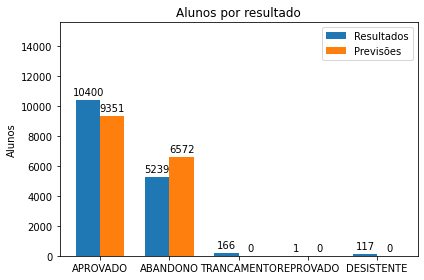

In [35]:
from sklearn.ensemble import AdaBoostClassifier

treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


adaboost = AdaBoostClassifier(random_state=42)
train_and_evaluate(adaboost, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

param_grid = [
    {'learning_rate': [0.1, 0.3, 1, 3], 'n_estimators': [30, 10, 100], 'algorithm': ['SAMME'],},
    {'learning_rate': [0.1, 0.3, 1, 3], 'n_estimators': [10, 30, 100]} # Com o Samme.r, padrão
]


adaboost_cs = AdaBoostClassifier()


#calculate_with_grid_search(adaboost_cs, param_grid, treino_x, teste_x, treino_y, teste_y)

#### LogisticRegression

A acurácia foi 90.99%
Tempo de execução:: 3.6763553619384766s


/home/eliasb/Documentos/evasao_escolar/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


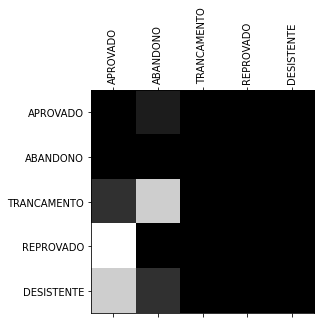

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 10433, 'ABANDONO': 5226, 'TRANCAMENTO': 154, 'REPROVADO': 1, 'DESISTENTE': 109}
{'APROVADO': 9382, 'ABANDONO': 6541, 'TRANCAMENTO': 0, 'REPROVADO': 0, 'DESISTENTE': 0}


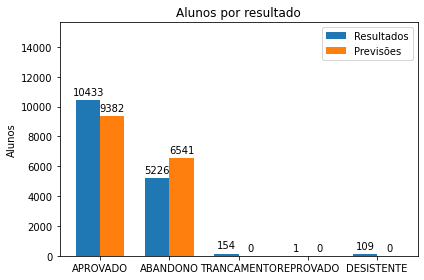

In [36]:
from sklearn.linear_model import LogisticRegression

treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


log_regression = LogisticRegression(random_state=42)
train_and_evaluate(log_regression, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

param_grid = [
    {'C': [0.1, 1, 3], 'fit_intercept': [False, True], 'max_iter': [1000, 10000] },
    {'C': [0.1, 1, 3], 'solver': ['newton-cg'], 'max_iter': [1000, 10000]}
]


log_regression_cs = LogisticRegression()


#calculate_with_grid_search(log_regression_cs, param_grid, treino_x, teste_x, treino_y, teste_y)

#### DecisionTreeClassifier

A acurácia foi 91.36%
Tempo de execução:: 0.017781734466552734s


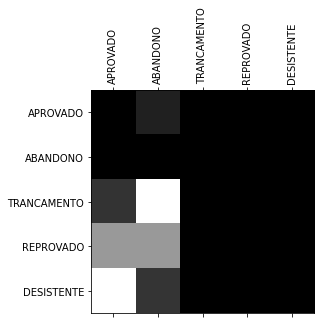

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 10316, 'ABANDONO': 5333, 'TRANCAMENTO': 166, 'REPROVADO': 2, 'DESISTENTE': 106}
{'APROVADO': 9331, 'ABANDONO': 6592, 'TRANCAMENTO': 0, 'REPROVADO': 0, 'DESISTENTE': 0}


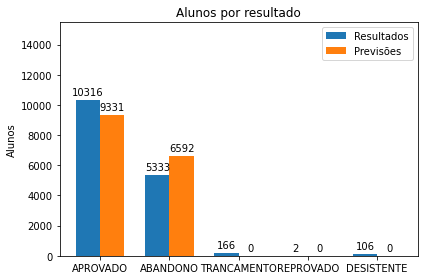

In [37]:
from sklearn.tree import DecisionTreeClassifier

treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


dec_tree = DecisionTreeClassifier(random_state=42)
train_and_evaluate(dec_tree, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

param_grid = [
    {'splitter': ['random'], 'criterion': ['entropy'], 'max_features': ['auto', 'sqrt', 'log2'] }
]


dec_tree_cs = DecisionTreeClassifier()


#calculate_with_grid_search(dec_tree_cs, param_grid, treino_x, teste_x, treino_y, teste_y)

In [38]:
"""
Plotar distribuições de previsões e resultados por status de matricula -> OK
Utilizar grid search e verificar quais os melhores possíveis hiperparâmetros -> OK
"""

'\nPlotar distribuições de previsões e resultados por status de matricula -> OK\nUtilizar grid search e verificar quais os melhores possíveis hiperparâmetros -> OK\n'

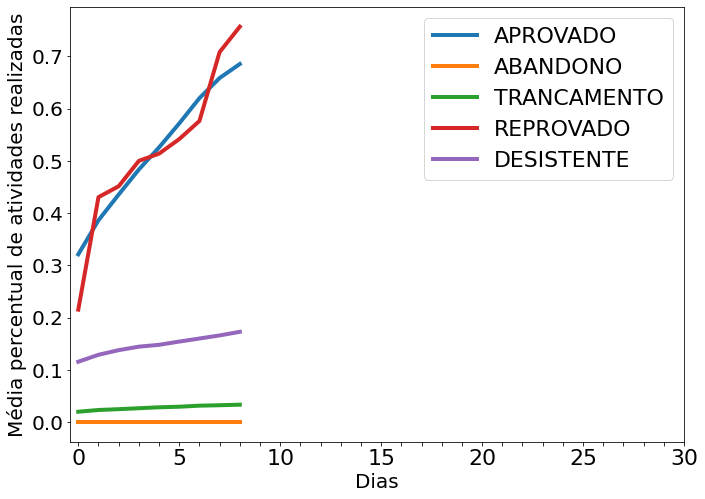

In [39]:
dataset[dataset['resultado'] == 0].filter(like=f'atividades_ate_dia_').aggregate('mean').div(18).plot(kind="line", figsize=(10,7.5), linewidth=4)
dataset[dataset['resultado'] == 1].filter(like=f'atividades_ate_dia_').aggregate('mean').div(18).plot(kind="line",linewidth=4)
dataset[dataset['resultado'] == 2].filter(like=f'atividades_ate_dia_').aggregate('mean').div(18).plot(kind="line",linewidth=4)
dataset[dataset['resultado'] == 3].filter(like=f'atividades_ate_dia_').aggregate('mean').div(18).plot(kind="line",linewidth=4)
dataset[dataset['resultado'] == 4].filter(like=f'atividades_ate_dia_').aggregate('mean').div(18).plot(kind="line",linewidth=4)

plt.legend(['APROVADO', 'ABANDONO', 'TRANCAMENTO', 'REPROVADO', 'DESISTENTE'], fontsize=22)
lgd = [i if i in [0, 5, 10, 15, 20, 25, 30] else "" for i in range(31)]
plt.xticks([i for i in range(31)], lgd, fontsize=22)
plt.yticks(fontsize=20)
plt.xlabel("Dias", fontsize=20)
plt.ylabel("Média percentual de atividades realizadas", fontsize=20)
fig = plt.gcf() 
fig.set_size_inches(11,8)
plt.show()

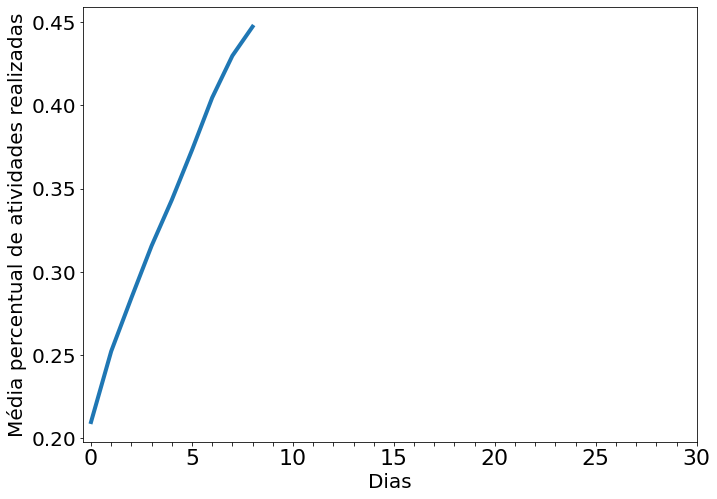

In [40]:
dataset.filter(like=f'atividades_ate_dia_').aggregate('mean').div(18).plot(kind="line", figsize=(10,7.5), linewidth=4)


lgd = [i if i in [0, 5, 10, 15, 20, 25, 30] else "" for i in range(31)]
plt.xticks([i for i in range(31)], lgd, fontsize=22)
plt.yticks(fontsize=20)
plt.xlabel("Dias", fontsize=20)
plt.ylabel("Média percentual de atividades realizadas", fontsize=20)
fig = plt.gcf() 
fig.set_size_inches(11,8)
plt.show()